In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.signal import welch
import warnings
warnings.filterwarnings(action='ignore');

In [104]:
def G(t,th):
    N = len(th);
    Nf = int(N/2);
    n = np.arange(N);
    out = np.zeros(Nf);
    out[0] = np.abs(np.sum(x[n])/N);
    for k in range(1,Nf):
        out[k] = 2*np.abs(np.sum(x[n]*np.exp(-1j*(2*np.pi/N)*n*k))/N);
    df = 1/max(t);
    freq = np.arange(Nf)*df;
    return freq,out;

In [105]:
def PSD(t,th):
    df = 1/max(t); N = len(th); Nf = int(N/2);
    freq,GG = G(t,th);
    psd = GG*GG
    psd = np.abs(psd);
    return freq,psd;

In [106]:
# Check

In [107]:
def log_interp(x,x_spec,y_spec):
    return 10**np.interp(np.log10(x),np.log10(x_spec),np.log10(y_spec));

In [108]:
def psd2th(freq,psd):  # IFFT method from Dirlik papar
    
    Nt = 1024; Nf = 512;
    fmax = max(freq); df = fmax/Nf;
    dt = 1/Nt/df; tmax = Nt*dt
    fi = np.linspace(df,fmax,Nf);
    G = log_interp(fi,freq,psd);
    F = np.zeros(Nt+1,'complex');
    Phi = np.random.uniform(low=-np.pi,high=np.pi,size=Nf);
    F[Nf+1:] = np.sqrt(G)*np.exp(1j*Phi)
    F[:Nf] = np.conjugate(np.flip(F[Nf+1:]))
    s = np.zeros(20*Nt);
    n = np.arange(-Nf,Nf+1);
    for i in range(20):
        for k in range(Nt):
            s[i*Nt+k] = df*np.sum(F*np.exp(1j*2*np.pi*k*n/Nt))
            
    ti = np.arange(20*Nt)*dt
    
    # grms 맞추는 과정은 내가 추가
    grms_spec = np.sqrt(np.trapz(G,fi));
    grms_syn = np.std(s)
    s *= grms_spec/grms_syn;
    
    return ti,s

In [109]:
# Smooth PSD
def Gs(f,A1,f1,Q1,A2,f2,Q2,fc):
    out1 = np.zeros(len(f)); out2 = np.zeros(len(f));
    for i in range(len(f)):
        if f[i] <= fc:
            out1[i] = A1/np.sqrt(1+((f1-f[i])**2)/(Q1**2));
            out2[i] = A2/np.sqrt(1+((f2-f[i])**2)/(Q2**2));
        else:
            out1[i] = 0;
            out2[i] = 0;
    out = out1 + out2;
    return out
def G3(f):
    A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
    return Gs(f,A1,f1,Q1,A2,f2,Q2,fc);

In [110]:
A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
Nt = 1024; Nf = 512; fmax = fc; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); 
freq3 = np.arange(Nf)*df; psd3 = G3(freq3);

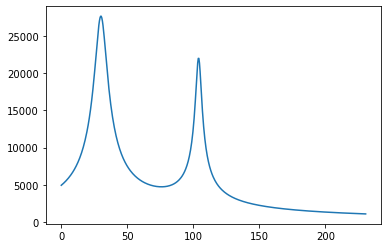

In [111]:
plt.plot(freq3,psd3);

In [112]:
ti,th = psd2th(freq3,psd3);

In [113]:
freq1,psd1 = PSD(ti,th);

In [122]:
freq2,psd2 = welch(th,fs = max(freq3)*2,nperseg=2**8);

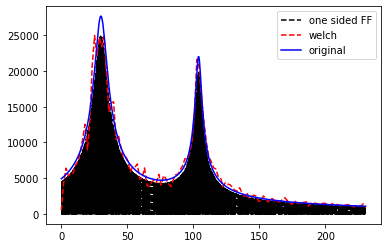

In [125]:
plt.plot(freq1,psd1,'k--',label='one sided FF');
plt.plot(freq2,psd2,'r--',label='welch');
plt.plot(freq3,psd3,'b-',label='original');
plt.legend(loc='upper right');